# Classical backtracking algorithm

In [14]:
import numpy as np
from math import sqrt, acos

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.circuit.quantumregister import Qubit
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [15]:
def in_row(grid: np.ndarray, row: int, val: int) -> bool:
    """Check whether val is in the row of the grid."""
    grid_size = len(grid)

    for i in range(grid_size):
        if grid[row, i] == val:
            return True

    return False


def in_column(grid: np.ndarray, column: int, val: int) -> bool:
    """Check whether val is in the column of the grid."""
    grid_size = len(grid)

    for i in range(grid_size):
        if grid[i, column] == val:
            return True

    return False


def in_box(grid: np.ndarray, row: int, column: int, val: int) -> bool:
    """Check whether val is in the inner box of the grid."""
    grid_size = len(grid)
    box_size = round(sqrt(grid_size))

    # calculate the upper-left corner of the inner box
    row_0 = (row // box_size) * box_size
    column_0 = (column // box_size) * box_size

    for r in range(box_size):
        for c in range(box_size):
            if grid[row_0 + r, column_0 + c] == val:
                return True

    return False


def is_distinct(grid: np.ndarray, row: int, column: int, val: int) -> bool:
    """Verify if the val in the given row/column is distinct."""
    return (
            not in_row(grid, row, val)
            and not in_column(grid, column, val)
            and not in_box(grid, row, column, val)
    )


def solve_sudoku_backtracking(grid: np.ndarray, solutions: [] = None):
    """Fill solutions with grids that satisfy Sudoku rules."""
    if solutions is None:
        solutions = []
    grid_size = len(grid[0])

    for r in range(grid_size):
        for c in range(grid_size):
            if grid[r, c] == -1:
                for val in range(grid_size):
                    if is_distinct(grid, r, c, val):
                        grid[r, c] = val
                        solve_sudoku_backtracking(grid, solutions)
                        grid[r, c] = -1
                return

    solutions.append(grid.copy())

## Run

In [16]:
sudoku = np.array(
    [[-1, -1, -1, -1],
     [-1, -1, -1, -1],
     [-1, -1, -1, -1],
     [-1, -1, -1, -1]]
)

my_solutions = []
solve_sudoku_backtracking(sudoku, my_solutions)

print(sudoku)
print(f"Number of solutions: {len(my_solutions)}")
# for i in range(len(my_solutions)):
#     print(f"Solution #{i}")
#     print(my_solutions[i], "\n")

[[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]
Number of solutions: 288


# Quantum algorithm

## Simulation setup

In [17]:
def new_circuit(quantum_bits: int, classical_bits: int) -> (QuantumRegister, ClassicalRegister, QuantumCircuit):
    """Create a new quantum circuit with given quantum volume."""
    qr = QuantumRegister(quantum_bits, "qreg")
    cr = ClassicalRegister(classical_bits, "creg")
    qc = QuantumCircuit(qr, cr)

    # set qubits to zero state
    for qubit in qr:
        qc.initialize('0', qubit)

    return qr, cr, qc


def simulate(qc: QuantumCircuit, shots: int = 1000, show_bloch: bool = False, title: str = None):
    """Draw the circuit, simulate a state vector and run simulations."""
    # simulate state vector
    statevector_backend = Aer.get_backend("statevector_simulator")
    statevector_job = execute(qc, backend=statevector_backend)
    statevector = statevector_job.result().get_statevector()

    # run simulations
    sim_backend = Aer.get_backend("qasm_simulator")
    sim_job = execute(qc, backend=sim_backend, shots=shots)
    counts = sim_job.result().get_counts()

    # display figures
    display(qc.draw(output="mpl"))
    if show_bloch:
        display(plot_bloch_multivector(statevector, figsize=(0.3, 0.3)))

    display(plot_histogram(counts, figsize=(6, 4), title=title))

## Superposition setup

In [18]:
def uno_superposition(qc: QuantumCircuit, q1: Qubit, q0: Qubit, value: int):
    """Encode given quantum state into the single value."""
    if value == 1:
        qc.x(q0)

    elif value == 2:
        qc.x(q1)

    elif value == 3:
        qc.x(q0)
        qc.x(q1)


def duo_superposition(qc: QuantumCircuit, q1: Qubit, q0: Qubit, value1: int, value2: int):
    """Encode given quantum state into the equal superposition of two values."""
    # swap to ensure value1 <= value2
    if value1 > value2:
        value1, value2 = value2, value1

    if (value1, value2) == (0, 1):
        qc.h(q0)

    elif (value1, value2) == (0, 2):
        qc.h(q1)

    elif (value1, value2) == (0, 3):
        qc.h(q0)
        qc.cx(q0, q1)

    elif (value1, value2) == (1, 2):
        qc.h(q0)
        qc.x(q1)
        qc.cx(q0, q1)

    elif (value1, value2) == (1, 3):
        qc.x(q0)
        qc.h(q1)

    elif (value1, value2) == (2, 3):
        qc.h(q0)
        qc.x(q1)


def trio_superposition(qc: QuantumCircuit, q1: Qubit, q0: Qubit,
                       value1: int, value2: int, value3: int):
    """Encode given quantum state into the equal superposition of three values."""
    values = [value1, value2, value3]

    # angle of rotation to achieve state [1/sqrt(3), sqrt(2)/sqrt(3)]
    theta_half = acos(1 / sqrt(3))
    theta = 2 * theta_half  # bloch sphere operation

    # 1, 2, 3
    if 0 not in values:
        qc.x(q0)
        qc.ry(theta, q1)
        qc.ch(q1, q0)

    # 0, 2, 3
    elif 1 not in values:
        qc.ry(theta, q1)
        qc.ch(q1, q0)

    # 0, 1, 3
    elif 2 not in values:
        qc.ry(theta, q0)
        qc.ch(q0, q1)

    # 0, 1, 2
    # elif 3 not in values:
    else:
        qc.ry(theta, q0)
        qc.ch(q0, q1)
        qc.x(q0)


def full_superposition(qc: QuantumCircuit, q1: Qubit, q0: Qubit):
    """Encode given quantum state into full superposition of all states."""
    qc.h(q0)
    qc.h(q1)


def create_superposition(qc: QuantumCircuit, q1: Qubit, q0: Qubit, init_values: []):
    """Introduce the given qubits into the equal superpositions of initial values."""
    size = len(init_values)
    if size == 1:
        uno_superposition(qc, q1, q0, init_values[0])

    elif size == 2:
        duo_superposition(qc, q1, q0, init_values[0], init_values[1])

    elif size == 3:
        trio_superposition(qc, q1, q0, init_values[0], init_values[1], init_values[2])

    # elif size == 4:
    else:
        full_superposition(qc, q1, q0)

### One state

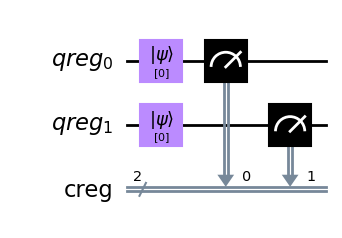

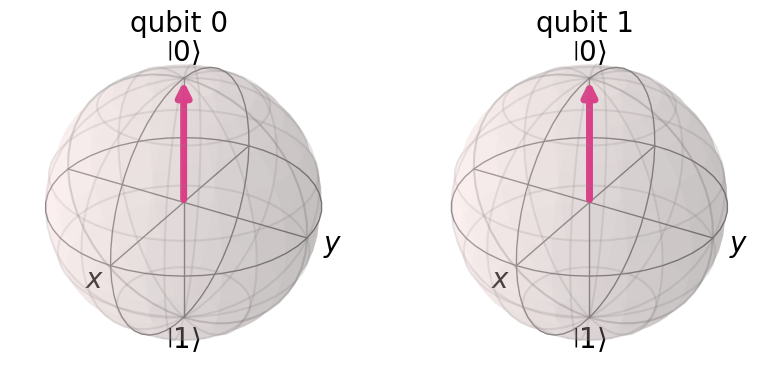

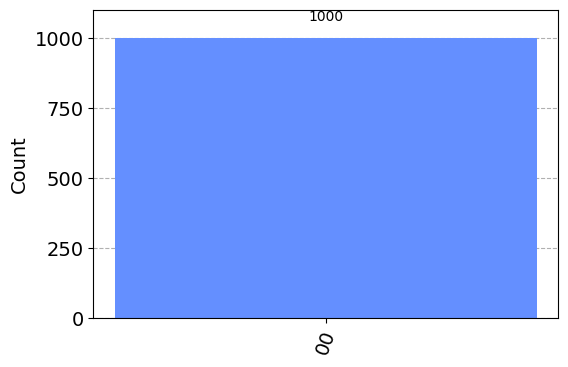

----------------------------------------------------------------------------------------------------


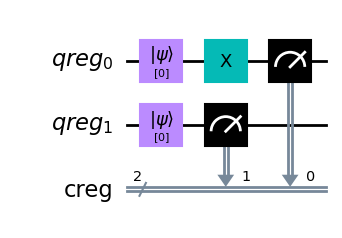

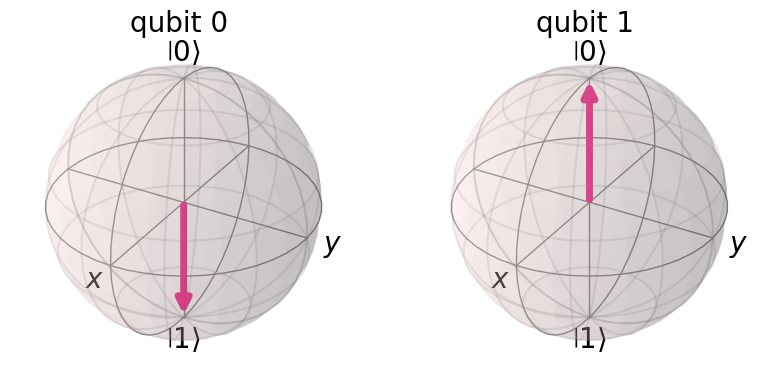

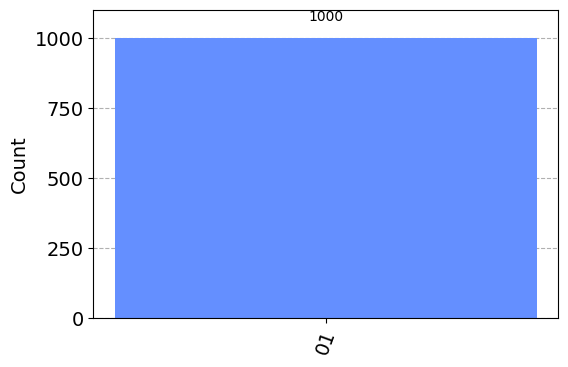

----------------------------------------------------------------------------------------------------


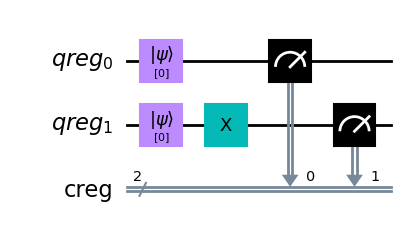

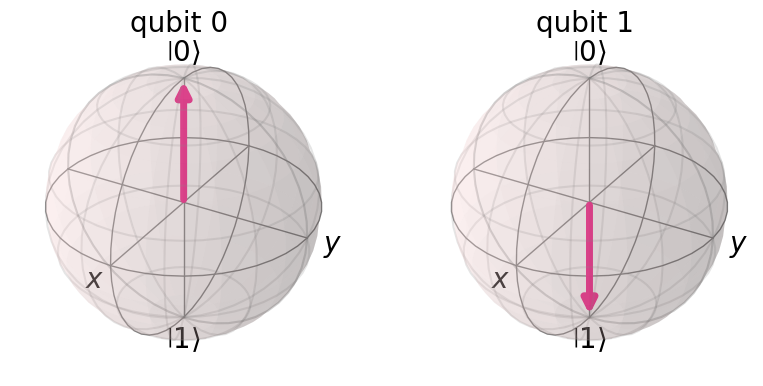

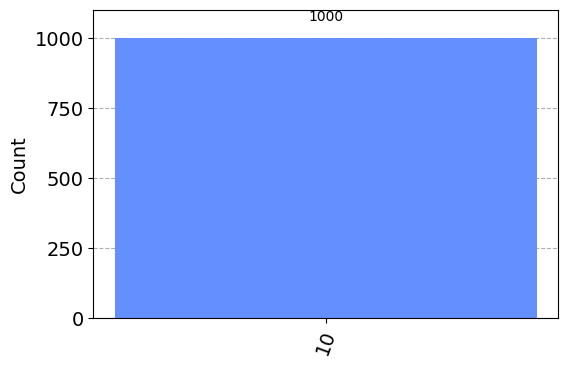

----------------------------------------------------------------------------------------------------


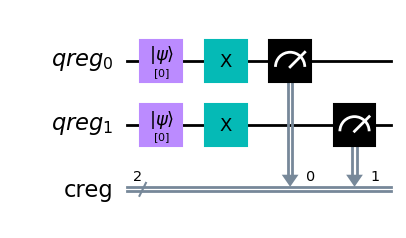

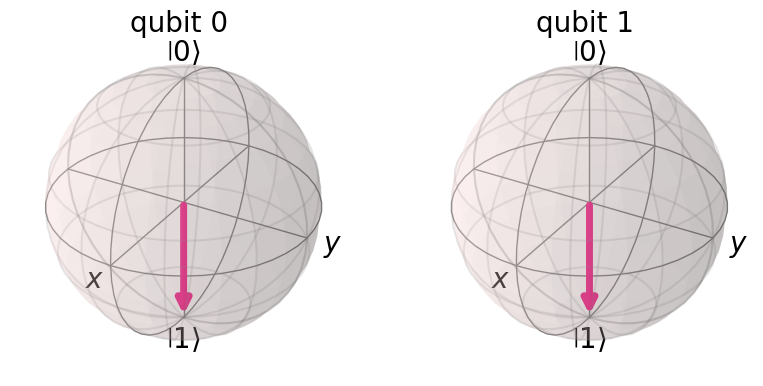

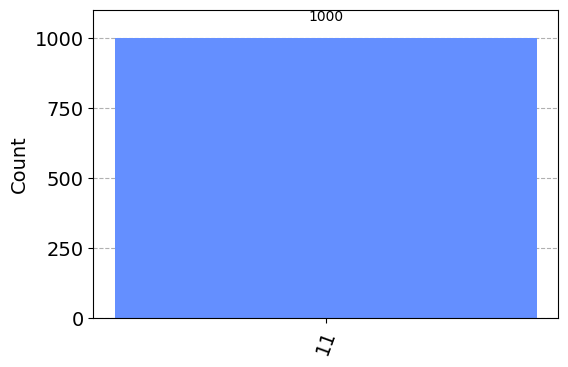

----------------------------------------------------------------------------------------------------


In [19]:
for init_values in range(4):
    qr, cr, qc = new_circuit(2, 2)
    uno_superposition(qc, qr[1], qr[0], init_values)
    qc.measure(qr, cr)

    simulate(qc, show_bloch=True)
    print("-" * 100)

### Two states

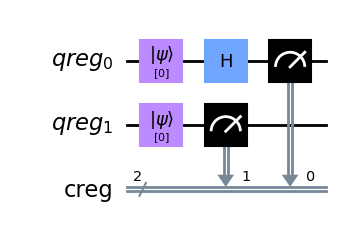

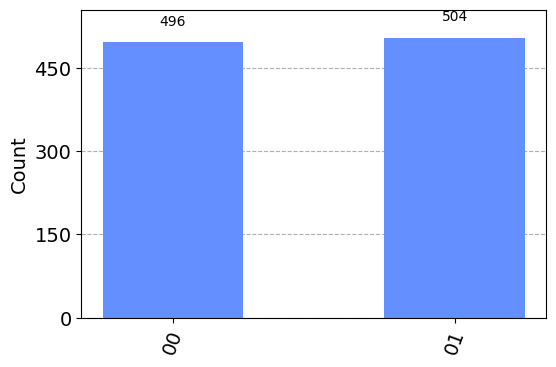

----------------------------------------------------------------------------------------------------


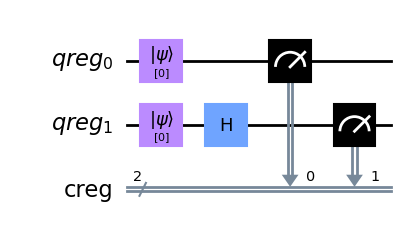

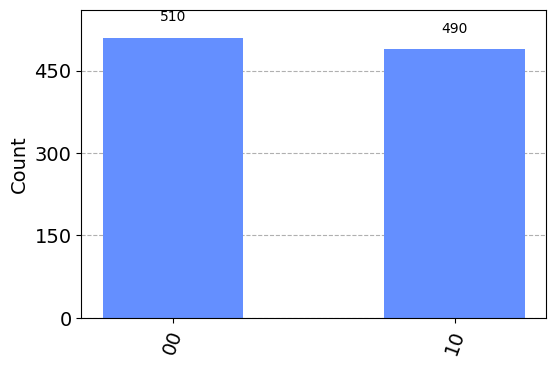

----------------------------------------------------------------------------------------------------


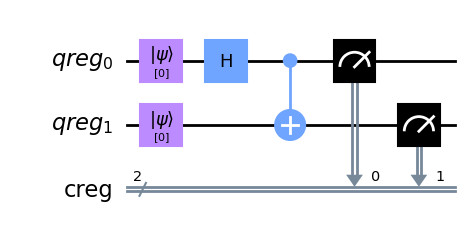

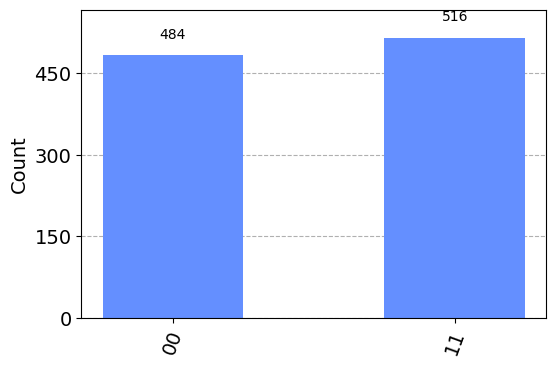

----------------------------------------------------------------------------------------------------


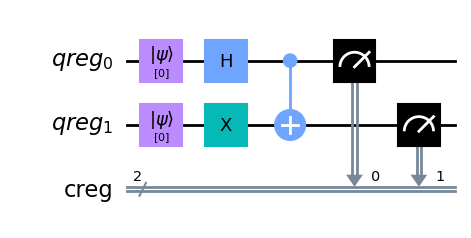

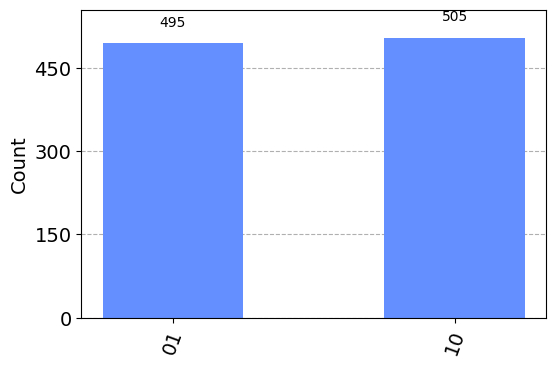

----------------------------------------------------------------------------------------------------


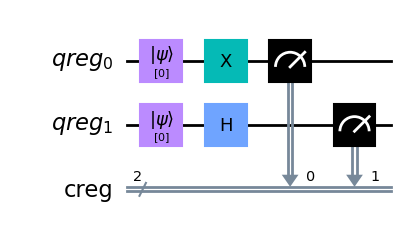

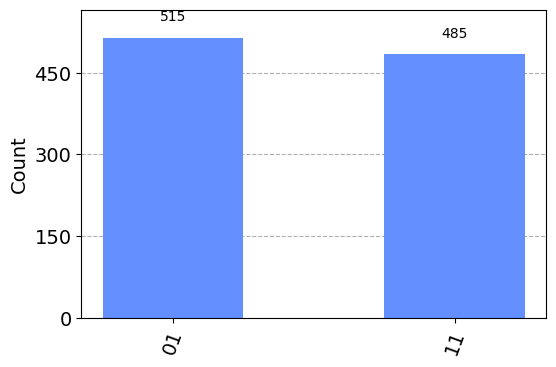

----------------------------------------------------------------------------------------------------


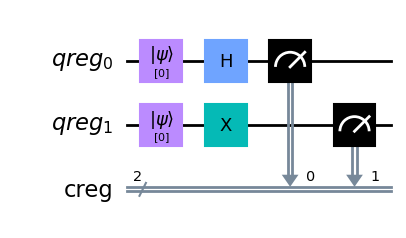

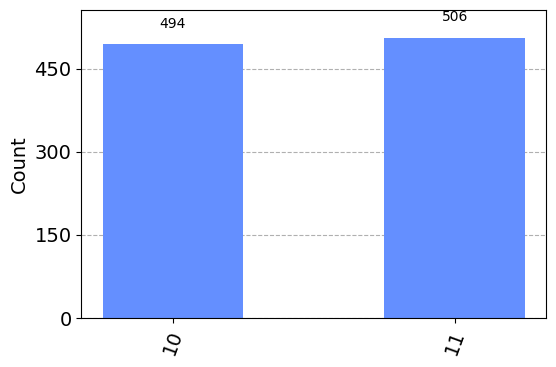

----------------------------------------------------------------------------------------------------


In [20]:
for init_values in [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]:
    qr, cr, qc = new_circuit(2, 2)
    duo_superposition(qc, qr[1], qr[0], *init_values)
    qc.measure(qr, cr)

    simulate(qc)
    print("-" * 100)

### Three states

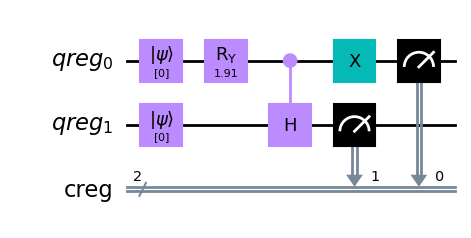

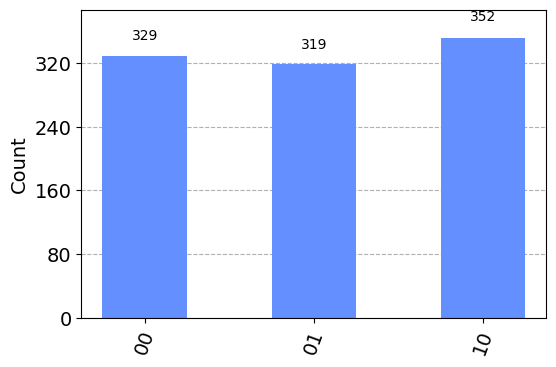

----------------------------------------------------------------------------------------------------


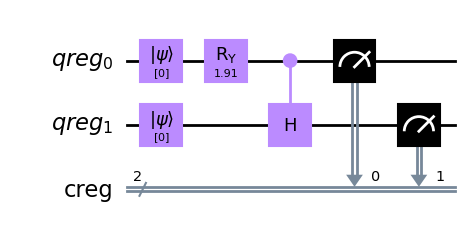

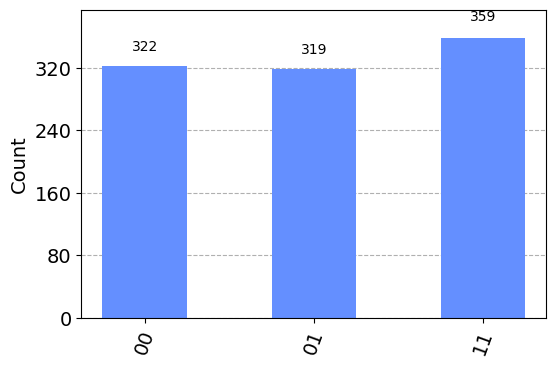

----------------------------------------------------------------------------------------------------


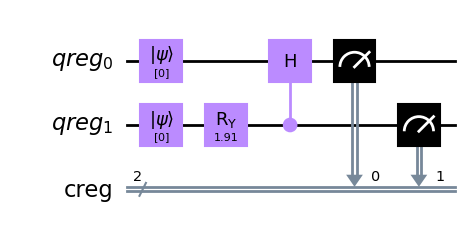

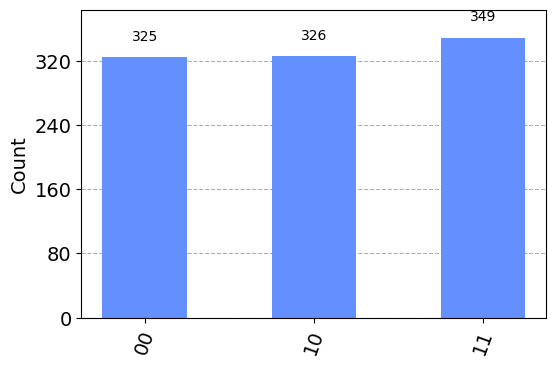

----------------------------------------------------------------------------------------------------


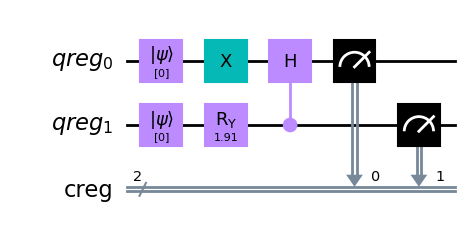

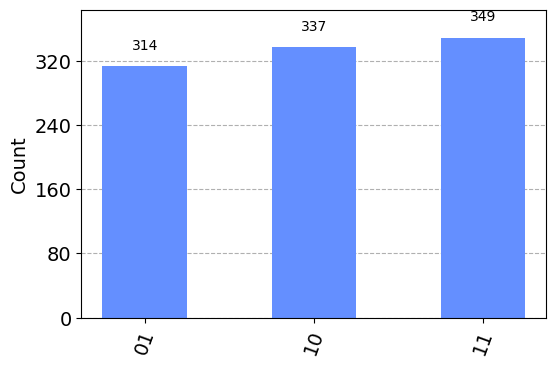

----------------------------------------------------------------------------------------------------


In [21]:
for init_values in [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]:
    qr, cr, qc = new_circuit(2, 2)
    trio_superposition(qc, qr[1], qr[0], *init_values)
    qc.measure(qr, cr)

    simulate(qc)
    print("-" * 100)

### Four states

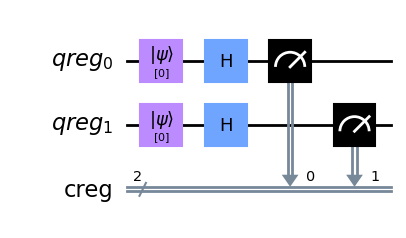

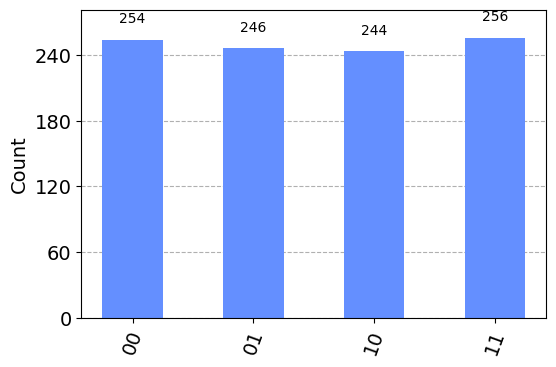

In [22]:
qr, cr, qc = new_circuit(2, 2)
full_superposition(qc, qr[1], qr[0])

qc.measure(qr, cr)
simulate(qc)

## Oracle

In [23]:
def two_qubit_xor(qc: QuantumCircuit, q1, q0, w1, w0, clause):
    """Set clause qubit to hold bitwise XOR value of the q1q0 and w1w0 values."""
    qc.x(w0)
    qc.x(w1)
    qc.ccx(q0, q1, clause)
    qc.ccx(q1, w0, clause)
    qc.ccx(w1, w0, clause)
    qc.ccx(q0, w1, clause)
    qc.x(clause)

    # interfere modifications
    qc.x(w0)
    qc.x(w1)

In [24]:
def oracle(qc: QuantumCircuit, clause_list: [], var_qubits: QuantumRegister, clause_qubits: QuantumRegister,
           output_qubit: Qubit):
    pass

## Find candidates

Preprocessing quantum algorithm with the candidate strategy.

Only setting qubits in superposition states that are legal in the initial sudoku board.

In [32]:
def field_legal_candidates(grid: np.ndarray, row: int, column: int) -> []:
    """Return legal candidates in the given row and column of the grid."""
    if grid[row, column] != -1:
        return [grid[row, column]]

    candidates = []
    grid_size = len(grid)

    for value in range(grid_size):
        if is_distinct(grid, row, column, value):
            candidates.append(value)

    return candidates


def legal_candidates(grid: np.ndarray) -> np.ndarray:
    """Return grid with legal candidates."""
    grid_size = len(grid)
    candidates = np.empty(shape=(grid_size, grid_size), dtype=object)

    for row in range(grid_size):
        for column in range(grid_size):
            candidates[row, column] = field_legal_candidates(grid, row, column)

    return candidates

In [34]:
sudoku = np.array(
    [[0, -1, -1, -1],
     [-1, 2, -1, 3],
     [-1, -1, -1, -1],
     [-1, -1, 3, -1]]
)

candidates = legal_candidates(sudoku)
candidates

array([[list([0]), list([1, 3]), list([1, 2]), list([1, 2])],
       [list([1]), list([2]), list([0, 1]), list([3])],
       [list([1, 2, 3]), list([0, 1, 3]), list([0, 1, 2]),
        list([0, 1, 2])],
       [list([1, 2]), list([0, 1]), list([3]), list([0, 1, 2])]],
      dtype=object)